In [517]:
# Load data

import _pickle as cp
import numpy as np

X, y = cp.load(open('winequality-white.pickle','rb'))

N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train

X_train_raw = X[:N_train]
y_train_raw = y[:N_train]
X_test_raw = X[N_train:]
y_test_raw = y[N_train:]

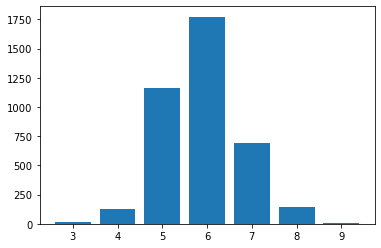

In [518]:
# Plot distribution of ys

import matplotlib.pyplot as plt

unique, counts = np.unique(y_train, return_counts=True)

plt.bar(unique, counts)
plt.show()

In [519]:
# Test a model:

import numpy as np

def mean_squared_error(predict, X, y):
    y_hat = predict(X)
    residuals = np.subtract(y, y_hat)
    squared_residuals = np.square(residuals)
    return np.mean(squared_residuals)

In [520]:
# Trivial model

import numpy as np

def train_trivial(X, y):
    global avg_y
    avg_y = np.average(y)

def predict_trivial(X):
    return np.repeat(avg_y, len(X))

In [521]:
# Test trivial model

train_trivial(X_train, y_train)
mse_train = mean_squared_error(predict_trivial, X_train, y_train)
mse_test = mean_squared_error(predict_trivial, X_test, y_test)

print('Mean squared error of trivial model:')
print('On train data ' + str(mse_train))
print('On test data ' + str(mse_test))

Mean squared error of trivial model:
On train data 0.7767772386501117
On test data 0.8138573000045535


In [522]:
# Normalize features

import numpy as np

X_means = np.mean(X_train_raw, axis=0)
X_stds = np.std(X_train_raw, axis=0)

X_train = np.subtract(X_train_raw, X_means)
X_train = np.divide(X_train, X_stds)

X_test = np.subtract(X_test_raw, X_means)
X_test = np.divide(X_test, X_stds)

In [523]:
# Linear regression

import numpy as np
from numpy.linalg import inv

def transform_const(X):
    return np.insert(X, 0, 1, axis=1)

def train_lin_reg(X, y):
    global weights
    X2 = transform_const(X)
    weights = inv(X2.transpose().dot(X2)).dot(X2.transpose()).dot(y)

def predict_lin_reg(X):
    return transform_const(X).dot(weights)

In [524]:
# Test linear regression

train_lin_reg(X_train, y_train)
mse_train = mean_squared_error(predict_lin_reg, X_train, y_train)
mse_test = mean_squared_error(predict_lin_reg, X_test, y_test)

print('Mean squared error of linear regression:')
print('On train data ' + str(mse_train))
print('On test data ' + str(mse_test))

Mean squared error of linear regression:
On train data 0.5639996173941924
On test data 0.5607292042283468


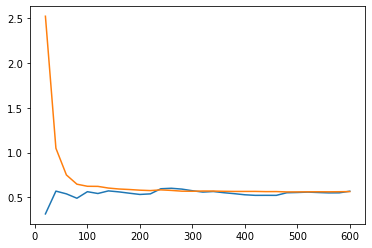

In [525]:
# Plot learning rate of linear regression

import numpy as np
import matplotlib.pyplot as plt

mse_train_arr = np.zeros(0)
mse_test_arr = np.zeros(0)
n_arr = np.zeros(0)

for i in range(20, 601, 20):
    X_curr = X_train[:i]
    y_curr = y_train[:i]
    
    train_lin_reg(X_curr, y_curr)
    mse_train = mean_squared_error(predict_lin_reg, X_curr, y_curr)
    mse_test = mean_squared_error(predict_lin_reg, X_test, y_test)
    
    n_arr = np.append(n_arr, i)
    mse_train_arr = np.append(mse_train_arr, mse_train)
    mse_test_arr = np.append(mse_test_arr, mse_test)

plt.plot(n_arr, mse_train_arr)
plt.plot(n_arr, mse_test_arr)
plt.show()

In [526]:
# Polynomial basis expansion

import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def transform_poly(X):
    poly = PolynomialFeatures(2)
    return poly.fit_transform(X)

In [527]:
# Linear regression with polynomial

import numpy as np
from numpy.linalg import inv

def train_lin_reg_poly(X, y):
    global weights
    X2 = transform_poly(X)
    weights = inv(X2.transpose().dot(X2)).dot(X2.transpose()).dot(y)

def predict_lin_reg_poly(X):
    return transform_poly(X).dot(weights)

In [528]:
# Ridge linear regression

import numpy as np
from sklearn.linear_model import Ridge

def train_ridge(X, y, alpha):
    global clf_ridge
    clf_ridge = Ridge(alpha)
    clf_ridge.fit(transform_poly(X), y)

def predict_ridge(X):
    res = clf_ridge.predict(transform_poly(X))
    return clf_ridge.predict(transform_poly(X))

In [529]:
# Lasso linear regression

import numpy as np
from sklearn.linear_model import Lasso

def train_lasso(X, y, alpha):
    global clf_lasso
    clf_lasso = Lasso(alpha)
    clf_lasso.fit(transform_poly(X), y)

def predict_lasso(X):
    return clf_lasso.predict(transform_poly(X))

In [530]:
# Fit alpha hyperparameter for a model

import numpy as np

N_vtrain = int(0.8 * N_train)
X_vtrain = X_train[:N_vtrain]
y_vtrain = y_train[:N_vtrain]
X_valid = X_train[N_vtrain:]
y_valid = y_train[N_vtrain:]
    
def find_alpha(train, predict):
    def check_alpha(alpha):
        train(X_vtrain, y_vtrain, alpha)
        mse = mean_squared_error(predict, X_valid, y_valid)
        return mse
    
    alphas = [0.01, 0.1, 1, 10, 100]
    res = map(check_alpha, alphas)
    return alphas[np.argmin(list(res))]

In [531]:
# Find optimal alpha hyperparameters for the two models

ridge_alpha = find_alpha(train_ridge, predict_ridge)
lasso_alpha = find_alpha(train_lasso, predict_lasso)

print('Ridge alpha: ' + str(ridge_alpha))
print('Lasso alpha: ' + str(lasso_alpha))

Ridge alpha: 10
Lasso alpha: 0.01


In [532]:
# Test ridge linear regression

train_ridge(X_train, y_train, ridge_alpha)
mse_train = mean_squared_error(predict_ridge, X_train, y_train)
mse_test = mean_squared_error(predict_ridge, X_test, y_test)

print('Mean squared error of ridge:')
print('On train data ' + str(mse_train))
print('On test data ' + str(mse_test))

Mean squared error of ridge:
On train data 0.49546310413856376
On test data 0.5116677456584307


In [533]:
# Test lasso linear regression

train_lasso(X_train, y_train, lasso_alpha)
mse_train = mean_squared_error(predict_lasso, X_train, y_train)
mse_test = mean_squared_error(predict_lasso, X_test, y_test)

print('Mean squared error of lasso:')
print('On train data ' + str(mse_train))
print('On test data ' + str(mse_test))

Mean squared error of lasso:
On train data 0.5138328252782884
On test data 0.5185523039167391


In [535]:
# Test linear regression with polynomial

train_lin_reg_poly(X_train, y_train)
mse_train = mean_squared_error(predict_lin_reg_poly, X_train, y_train)
mse_test = mean_squared_error(predict_lasso, X_test, y_test)

print('Mean squared error of linear regression with polynomial expansion:')
print('On train data ' + str(mse_train))
print('On test data ' + str(mse_test))

Mean squared error of linear regression with polynomial expansion:
On train data 0.4952209887778066
On test data 0.5185523039167391
